In [5]:
from IPython.display import Image, display
import re
from tqdm import tqdm
from ast import literal_eval
import os
import vcf
import gzip
from tqdm import tqdm
from collections import Counter
import pandas as pd
import os
import numpy as np
import itertools
import re
import matplotlib.pyplot as plt
import numpy as np
from pysam import VariantFile
import json
import pysam
import seaborn as sns
import plotly.express as px 
from statistics import mean
import statistics

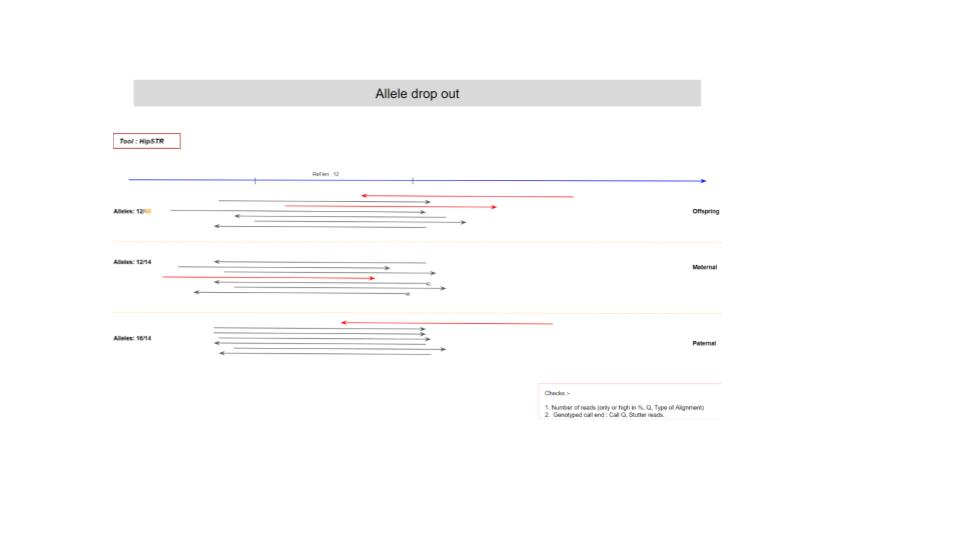

In [2]:
display(Image(filename='../../Analysis_KT/Calls_stats/Call qualities stutter dp.jpg'))

### Here we are taking the reference as STRaw file to check there is any regions with "Allele drop out" compared to parents.

##### HipSTR :       Offspring - HG00405
##### STRaw :        Maternal - HG00404,  Paternal - HG00403 


In [62]:
Trio_files = {}

with open('../1KG_Trio_Samples.tsv') as file_ids:
    file_ids.readline()
    
    for file in tqdm(file_ids):
        
        file = file.strip().split('\t')
        Trio_files[file[0]] = file[3], file[4]


597it [00:00, 369266.99it/s]


In [63]:
# Maternal and Paternal STRaw genotypes are being returned.

maternal_region_info = {}
paternal_region_info = {}

def parents_files(maternal_infile, paternal_infile):
    
    with gzip.open(f'../../data_pysam/STRaw_files/{maternal_infile}_straweCall.tsv.gz', 'rt') as maternal_regions, gzip.open(f'../../data_pysam/STRaw_files/{paternal_infile}_straweCall.tsv.gz', 'rt') as paternal_regions:
            maternal_regions.readline()
            paternal_regions.readline()
            
            # Maternal regions
            for regions_info in tqdm(maternal_regions):
                
                regions_info = regions_info.strip().split('\t')
                
                # ignoring the substitutions & same as refn.
                if regions_info[-3].startswith('(ref') or regions_info[-3].startswith('(S'): continue
                
                #
                m_region = f'{regions_info[0]}:{regions_info[1]}-{regions_info[2]}'
                set_alleles_info = re.split(r"[,:\s]\s*", regions_info[-2])
                
                # set of alleles and supporting reads
                set_alleles = set_alleles_info[0::2]
                alleles_supporting_reads = set_alleles_info[1::2]
                
                # updating in the dictionary.
                maternal_region_info[m_region] = set_alleles, alleles_supporting_reads, regions_info[-1]

                
            # Paternal regions
            for regions_info in tqdm(paternal_regions):
                
                regions_info = regions_info.strip().split('\t')
                
                # ignoring the substitutions & same as refn.
                if regions_info[-3].startswith('(ref') or regions_info[-3].startswith('(S'): continue
                
                #
                p_region = f'{regions_info[0]}:{regions_info[1]}-{regions_info[2]}'
                set_alleles_info = re.split(r"[,:\s]\s*", regions_info[-2])
                
                # set of alleles and supporting reads
                set_alleles = set_alleles_info[0::2]
                alleles_supporting_reads = set_alleles_info[1::2]
                
                # updating in the dictionary.
                paternal_region_info[p_region] = set_alleles, alleles_supporting_reads, regions_info[-1]

            
    return maternal_region_info, paternal_region_info
    
# parents_files('HG00403','HG00404')

In [146]:
#

def offspring_file(file):
    
    Trio_id = file.split('_')[0]
    
    # Passing the parents files to get return the dictionary with { region:
    maternal_file = Trio_files[Trio_id][0]
    paternal_file = Trio_files[Trio_id][1]
    # dictionary having maternal and paternal regions.    
    Allele_drop_out_dicts = parents_files(maternal_file, paternal_file)
    
    # outfile
    out = open('../../Analysis_KT/Calls_stats/Allele_DropOut.tsv', 'w')
    
    with gzip.open(f'../../Analysis_AV/denovo/{file}', 'rt') as denovo_regions:
        denovo_regions.readline()
        
        for dregion_info in denovo_regions:
            
            dregion_info = dregion_info.strip().split('\t')
            if dregion_info[-1] != '-': continue
            
            # Offspring info
            denovo_allele = dregion_info[-6]
            offspring_alleles = dregion_info[-13]
            offspring_region = f'{dregion_info[0]}:{dregion_info[1]}-{dregion_info[2]}'
            repeat_len = int(dregion_info[2]) - int(dregion_info[1])
            repeat_motif = dregion_info[3]
            
            # parent info
            maternal_regions = Allele_drop_out_dicts[0]
            paternal_regions = Allele_drop_out_dicts[1]
            
            # Maternal
            if offspring_region in maternal_regions and denovo_allele in maternal_regions[offspring_region][0]:
                
                STRaw_totalm_reads = int(maternal_regions[offspring_region][-1])
                m_alleles = maternal_regions[offspring_region][0]
                m_read_counts = maternal_regions[offspring_region][1]
                DropedAllele_supportingm_reads = m_read_counts[m_alleles.index(denovo_allele)]                
                Allele_droped_out_m = f'{denovo_allele}:{round((int(DropedAllele_supportingm_reads)/int(STRaw_totalm_reads))*100)}:Maternal'
                
                print(offspring_region,offspring_alleles, Allele_droped_out_m,f'{DropedAllele_supportingm_reads}/{STRaw_totalm_reads}', file=out, sep='\t')
            
            # Paternal            
            if offspring_region in paternal_regions and denovo_allele in paternal_regions[offspring_region][0]:
                
                STRaw_totalp_reads = int(paternal_regions[offspring_region][-1])
                p_alleles = paternal_regions[offspring_region][0]
                p_read_counts = paternal_regions[offspring_region][1]                
                DropedAllele_supportingp_reads = p_read_counts[p_alleles.index(denovo_allele)]                
                Allele_droped_out_p = f'{denovo_allele}:{round((int(DropedAllele_supportingp_reads)/int(STRaw_totalp_reads))*100)}:Paternal'

                
                print(offspring_region,offspring_alleles, Allele_droped_out_p,f'{DropedAllele_supportingp_reads}/{STRaw_totalp_reads}', file=out, sep='\t')


In [147]:
#
offspring_file('TRIO0001_denovo.tsv.gz')

3646473it [00:04, 734233.21it/s]
3656211it [00:05, 729080.08it/s]


In [145]:
len_wise_not_denovo = 0
len_wise_denovo = 0
i = 0

with gzip.open(f'../../Analysis_AV/denovo/TRIO0002_denovo.tsv.gz', 'rt') as denovo_regions:
        denovo_regions.readline()
        
        for dregion_info in tqdm(denovo_regions):
            
            dregion_info = dregion_info.strip().split('\t')
            if dregion_info[-1] != '-': continue
            i += 1
            
            #
            list_alleles = dregion_info[8].split('|') + dregion_info[12].split('|')
            
            if dregion_info[-6] in list_alleles:  
                len_wise_not_denovo += 1
            
            if dregion_info[-6] not in list_alleles:
                len_wise_denovo += 1

print(len_wise_denovo, len_wise_not_denovo, len_wise_denovo+len_wise_not_denovo, i)

49053it [00:00, 385062.62it/s]

6648 3635 10283 10283
